In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import time
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,root_mean_squared_error
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor

from utils import clean_data
from utils import split_trajectories
from utils import replicate_initial_position_by_block
from utils import get_n_trajectories
from utils import plot_y_yhat
from utils import add_three_body_features

In [46]:
train = pd.read_csv('../data/X_train.csv')
test =  pd.read_csv('../data/X_test.csv')
sample_submission = pd.read_csv('../data/sample_submission.csv')#This is a file with random numbers as predictions
                                                                #dans le futur fichier résultat ne pas mettre l'index

In [47]:
train_cleaned=clean_data(train)

In [48]:
train_after_split, validation_after_split, test_after_split = split_trajectories(train_cleaned)

In [49]:
train_entry=replicate_initial_position_by_block(train_after_split)
validation_entry=replicate_initial_position_by_block(validation_after_split)
test_entry=replicate_initial_position_by_block(test_after_split)

In [50]:
velocity_cols = ['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3']

train_cleaned_no_velocity = train_cleaned.drop(columns=['Id'] + velocity_cols, errors='ignore')

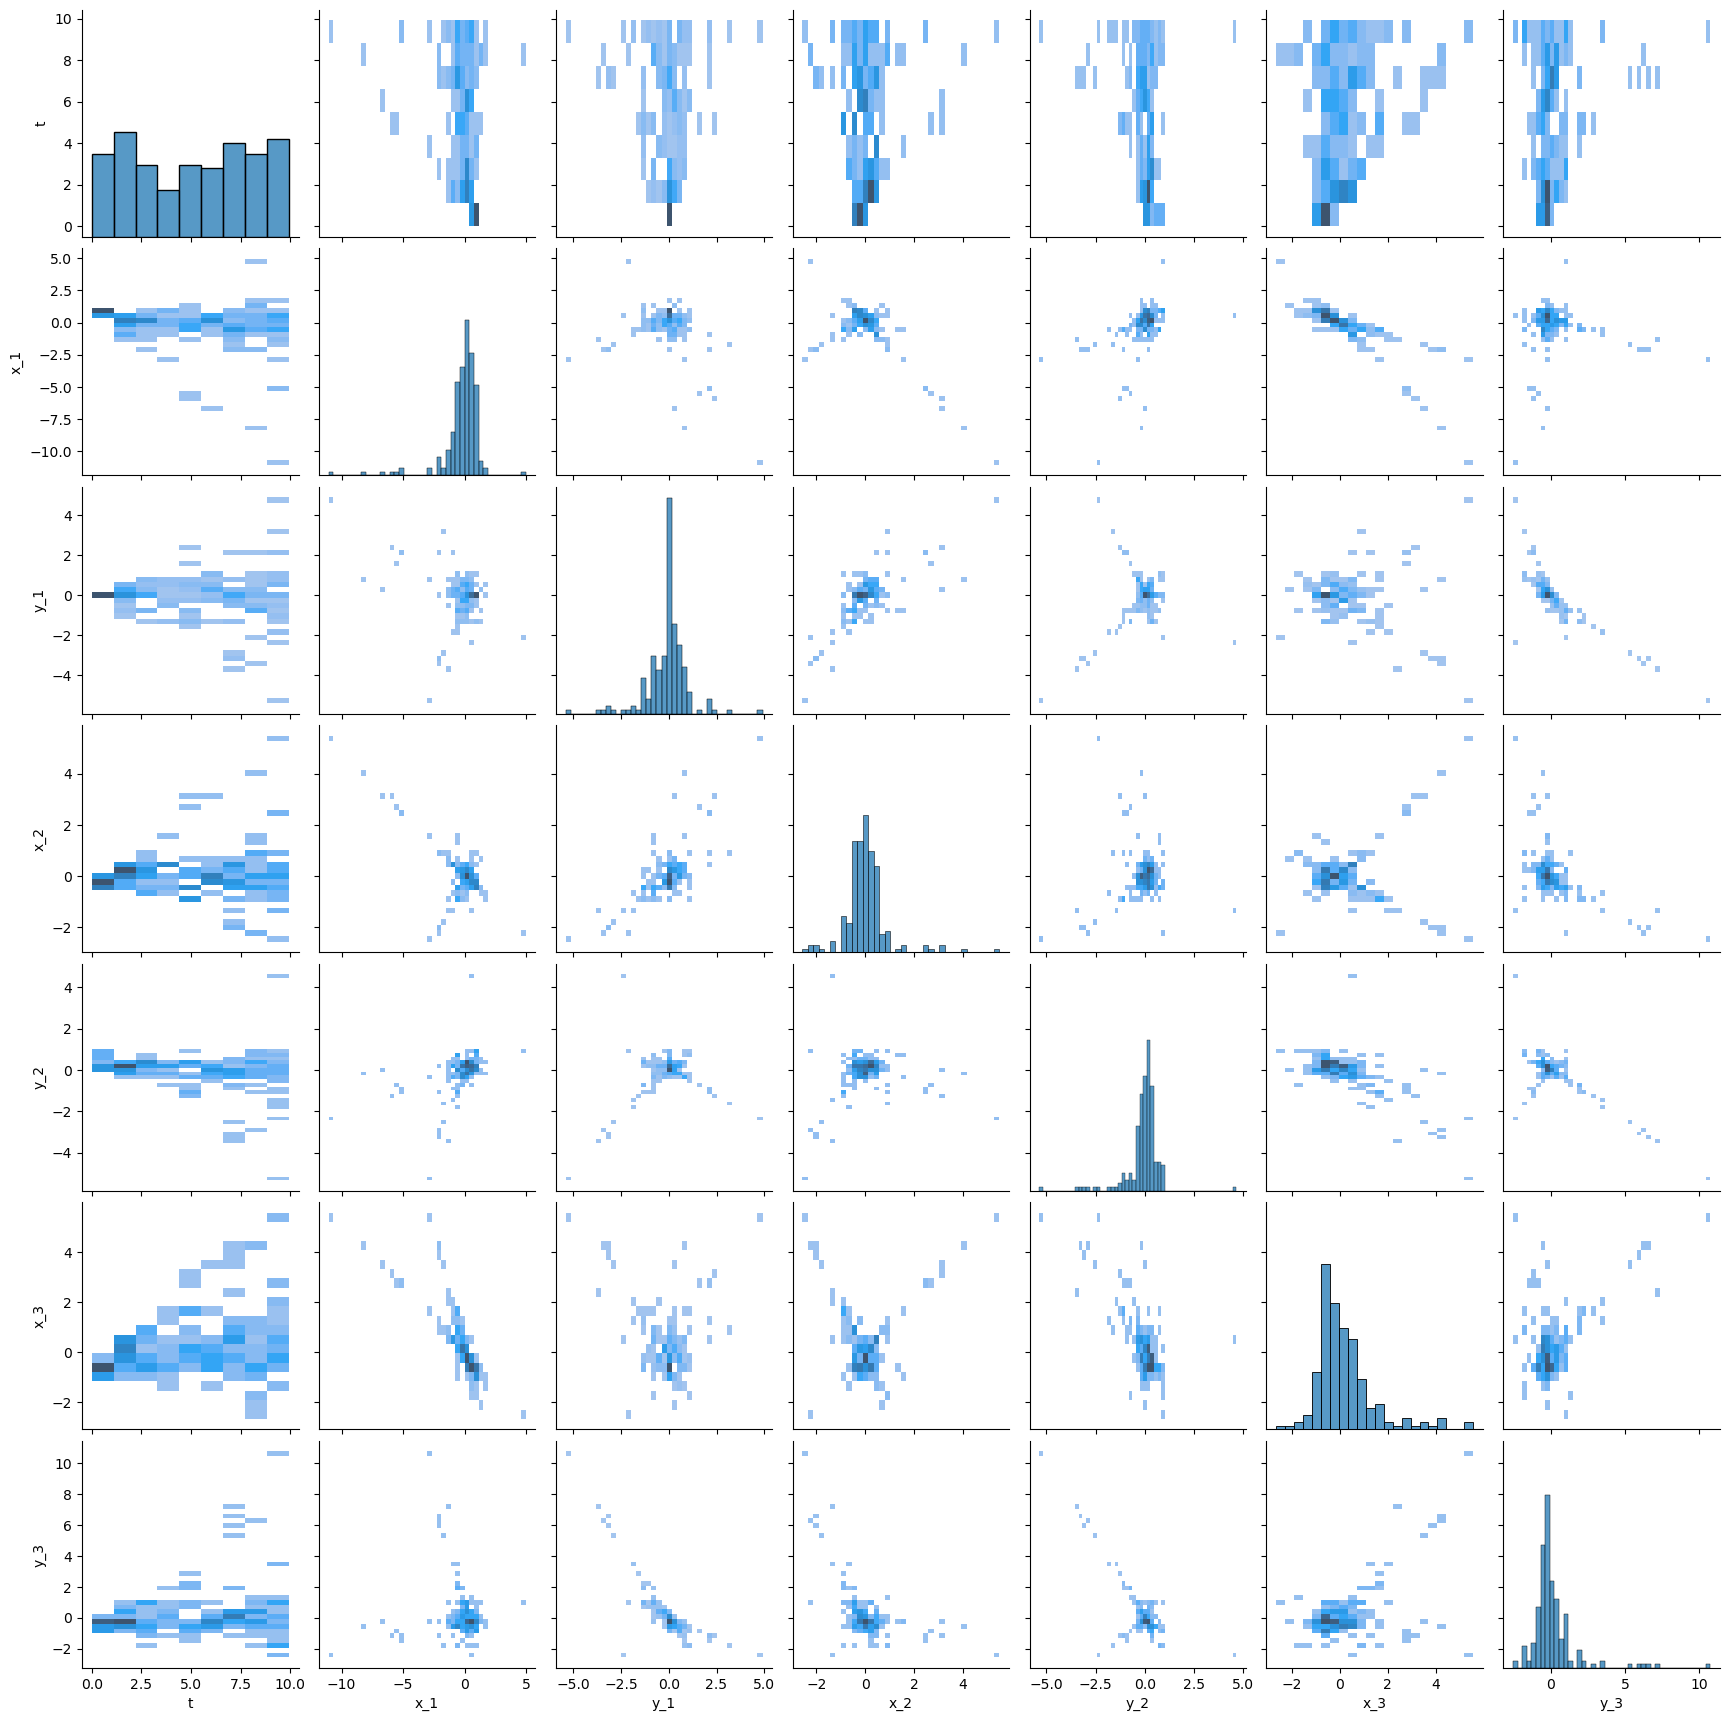

In [51]:
sns.pairplot(train_cleaned_no_velocity.sample(200), kind="hist")

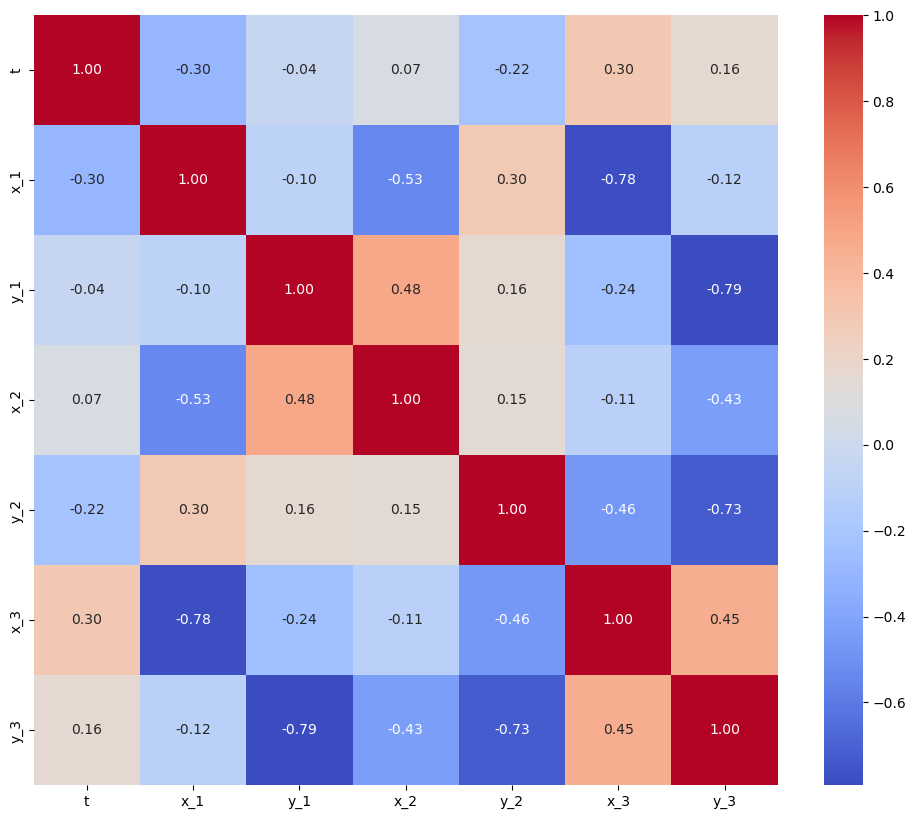

In [52]:
corr = train_cleaned_no_velocity.corr()

plt.figure(figsize=(12,10))  # tu peux ajuster largeur et hauteur
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.show()

In [53]:
corr_long = corr.abs().stack().reset_index()
corr_long.columns = ['Feature1', 'Feature2', 'AbsCorr']
corr_long = corr_long[corr_long['Feature1'] != corr_long['Feature2']]
corr_long = corr_long.drop_duplicates(subset=['AbsCorr'])
corr_long_sorted = corr_long.sort_values(by='AbsCorr', ascending=False)
corr_long_sorted

,Feature1,Feature2,AbsCorr
20,y_1,y_3,0.792859
12,x_1,x_3,0.780996
34,y_2,y_3,0.728556
10,x_1,x_2,0.534279
17,y_1,x_2,0.484456
33,y_2,x_3,0.464365
41,x_3,y_3,0.453896
27,x_2,y_3,0.430117
5,t,x_3,0.302133
11,x_1,y_2,0.299352


In [54]:
pipeline = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

Baseline RMSE: 1.46098232953751
Removed y_3, RMSE = 1.4610
Removed x_3, RMSE = 1.4610
Removed x_2, RMSE = 1.4794
Removed y_2, RMSE = 1.5005
Removed x_1, RMSE = 1.5005
Removed y_1, RMSE = 1.5005
Features finally removed: ['y_3', 'x_3', 'x_2', 'y_2', 'x_1', 'y_1']


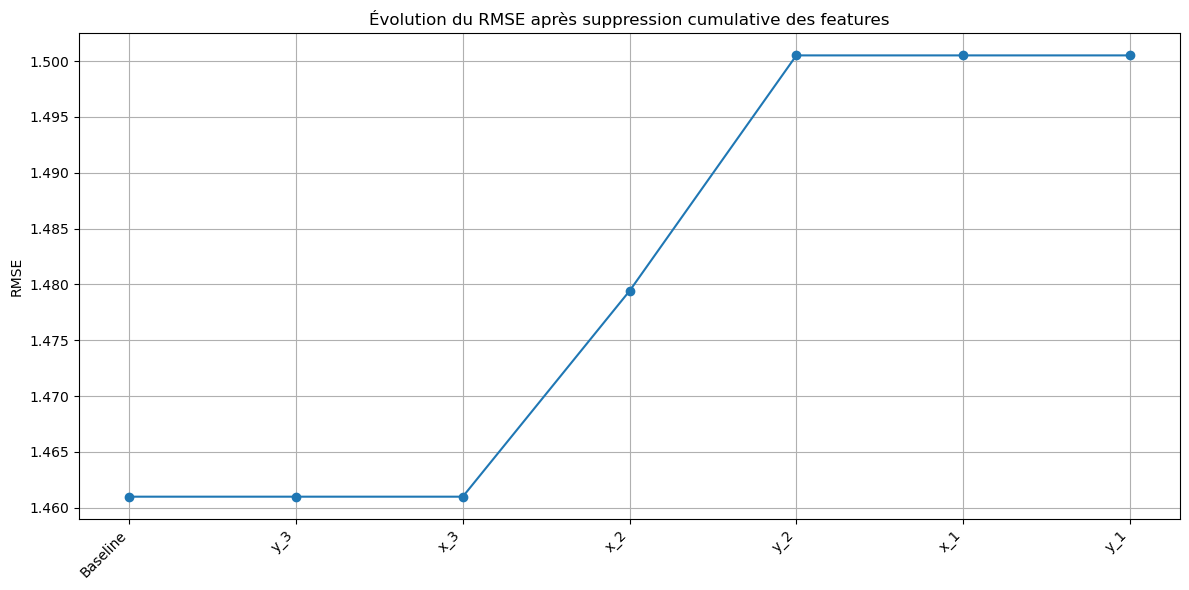

In [55]:
# Colonnes d'entrée dans l'ordre souhaité
input_cols = [
    't',
    'x_1', 'y_1',
    'x_2', 'y_2',
    'x_3', 'y_3'
]

# Colonnes cibles : positions uniquement
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

# Préparer les datasets d'entraînement
X_train = train_entry[input_cols].copy()          
y_train = train_after_split[target_cols].copy()

# Préparer les datasets de validation
X_val = validation_entry[input_cols].copy()
y_val = validation_after_split[target_cols].copy()


# 2. Fonction pour tester l'impact de la suppression d'une variable sur RMSE
def test_feature_removal(pipeline, X_train, y_train, X_val, y_val, feature_to_remove):
    X_train_mod = X_train.drop(columns=[feature_to_remove])
    X_val_mod = X_val.drop(columns=[feature_to_remove])
    
    pipeline.fit(X_train_mod, y_train)
    y_pred = pipeline.predict(X_val_mod)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

    
# Copier les datasets pour suppression cumulative
X_train_temp = X_train.copy()
X_val_temp = X_val.copy()

removed_features = []

# Baseline RMSE avec toutes les features
pipeline.fit(X_train_temp, y_train)
y_pred_base = pipeline.predict(X_val_temp)
baseline_rmse = np.sqrt(mean_squared_error(y_val, y_pred_base))
print("Baseline RMSE:", baseline_rmse)

# Liste pour stocker l'évolution du RMSE
rmse_list = [baseline_rmse]
features_list = ['Baseline']

# Boucle sur les paires de features triées par corrélation décroissante
for _, row in corr_long_sorted.iterrows():
    f1, f2 = row['Feature1'], row['Feature2']
    
    # Supprimer la deuxième feature de la paire si elle n'a pas déjà été supprimée
    if f2 not in removed_features:
        X_train_temp.drop(columns=[f2], inplace=True, errors='ignore')
        X_val_temp.drop(columns=[f2], inplace=True, errors='ignore')
        
        # Calculer le RMSE avec le dataset réduit
        pipeline.fit(X_train_temp, y_train)
        y_pred = pipeline.predict(X_val_temp)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        print(f"Removed {f2}, RMSE = {rmse:.4f}")
        
        # Stocker pour graphique
        removed_features.append(f2)
        rmse_list.append(rmse)
        features_list.append(f2)

print("Features finally removed:", removed_features)

# --- Graphique RMSE vs Features supprimées ---
plt.figure(figsize=(12,6))
plt.plot(rmse_list, marker='o')
plt.xticks(range(len(features_list)), features_list, rotation=45, ha='right')
plt.ylabel("RMSE")
plt.title("Évolution du RMSE après suppression cumulative des features")
plt.grid(True)
plt.tight_layout()
plt.show()

RMSE validation: 1.4333705602661688


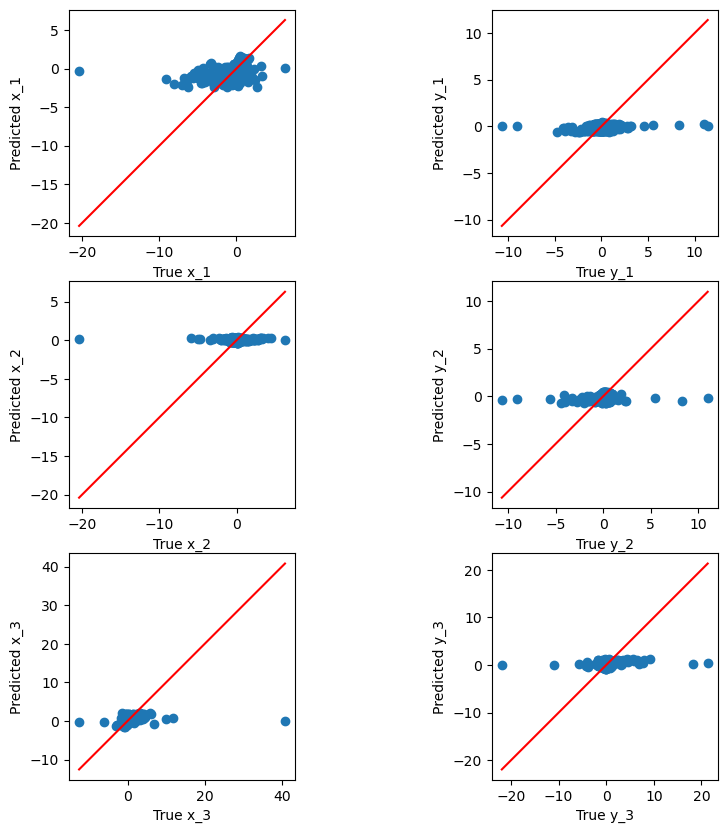

In [56]:
pipeline2 = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

input_cols = ['t', 'x_1', 'y_1', 'x_2', 'y_2']#without x3 y3
target_cols = ['x_1', 'y_1', 'x_2', 'y_2', 'x_3', 'y_3']

X_train = train_entry[input_cols]          
y_train = train_after_split[target_cols] 

pipeline2.fit(X_train, y_train)
X_val = validation_entry[input_cols]
y_val = validation_after_split[target_cols]

y_pred_val = pipeline2.predict(X_val) 

rmse_validation = root_mean_squared_error(y_val,y_pred_val)
print("RMSE validation:", rmse_validation)


plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")

In [57]:
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,5), max_features=None):
    """
    Validate polynomial regression models with optional regularization.
    Returns best model, RMSE, degree, regularization type, and alpha.
    Also prints elapsed time.
    """
    start_time = time.time()  # start timing

    best_rmse = np.inf
    best_model = None
    best_degree = None
    best_alpha = None
    best_reg = None

    alphas = np.logspace(-5, 5, 11)

    for degree in tqdm(degrees, desc="Testing degrees"):
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        poly.fit(X_train)
        n_features = poly.n_output_features_
        print(f"Degree {degree}: {n_features} features")

        if max_features and n_features > max_features:
            print(f" Skipped degree {degree} (too many features: {n_features})")
            continue

        for alpha in alphas:
            if regressor == 'L1':
                model = Lasso(alpha=alpha, max_iter=5000, random_state=42)
            elif regressor == 'L2':
                model = Ridge(alpha=alpha, random_state=42)
            else:
                model = LinearRegression()
                alpha = None  # pas de régularisation
                regressor = 'None'

            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('poly', poly),
                ('reg', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            rmse = root_mean_squared_error(y_val, y_pred)

            if rmse < best_rmse:
                best_rmse = rmse
                best_model = pipe
                best_degree = degree
                best_alpha = alpha
                best_reg = regressor

    elapsed_time = time.time() - start_time  # end timing
    print(f"\n⏱️ Total elapsed time: {elapsed_time:.2f} seconds")
    print(f"✅ Best model: degree={best_degree}, RMSE={best_rmse:.4f}, reg={best_reg}, alpha={best_alpha}")

    return best_model, best_rmse, best_degree, best_reg, best_alpha

In [ ]:
best_model_L1, best_rmse_L1, best_degree_L1, best_reg_L1, best_alpha_L1 = validate_poly_regression(
   X_train, y_train,X_val,y_val, regressor='L1'
)

best_model_L2, best_rmse_L2, best_degree_L2, best_reg_L2, best_alpha_L2 = validate_poly_regression(
   X_train, y_train,X_val,y_val, regressor='L2'
)

best_model_L, best_rmse_L, best_degree_L, best_reg_L, best_alpha_L = validate_poly_regression(
   X_train, y_train,X_val,y_val
)

Testing degrees:   0%|          | 0/4 [00:00<?, ?it/s]

Degree 1: 5 features


Testing degrees:  25%|██▌       | 1/4 [00:13<00:39, 13.29s/it]

Degree 2: 20 features


Testing degrees:  50%|█████     | 2/4 [00:56<01:01, 30.79s/it]

Degree 3: 55 features


Testing degrees:  75%|███████▌  | 3/4 [04:43<02:00, 120.39s/it]

Degree 4: 125 features


In [ ]:
#AJOUTER HEATMAP COEFF POLYNAMNIAL MODEL

In [ ]:
y_pred_val = best_model_L2.predict(X_val) 

rmse_validation = root_mean_squared_error(y_val,y_pred_val)
print("RMSE validation:", rmse_validation)

plot_y_yhat(y_val.values, y_pred_val, plot_title="plot")

In [ ]:
X_train_enriched = add_three_body_features(train_entry)
X_val_enriched   = add_three_body_features(validation_entry)

In [ ]:
# Variables à considérer (tous les groupes)
all_features = [
    't', 'x_1', 'y_1', 'x_2', 'y_2',
    'r_12', 'r_13', 'r_23',
    'inv_r_12', 'inv_r_13', 'inv_r_23',
    'r12_over_r13', 'r12_over_r23', 'r13_over_r23',
    'triangle_area',
    'd1_cm', 'd2_cm', 'd3_cm'
]

# Extraire les colonnes d'intérêt
X_sel = X_train_enriched[all_features].copy()

# Calcul de la matrice de corrélation
corr_matrix = X_sel.corr()

# Mettre sous forme de paires
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Supprimer doublons et diagonale
corr_pairs = corr_pairs[corr_pairs['Feature_1'] < corr_pairs['Feature_2']]

# Garder uniquement les corrélations fortes (|corr| > 0.70)
strong_corr = corr_pairs[abs(corr_pairs['Correlation']) > 0.70].sort_values(by='Correlation', ascending=False)

# Compter combien
nb_strong = strong_corr.shape[0]

print(f"📊 Nombre de paires de variables fortement corrélées (|corr| > 0.70) : {nb_strong}")
display(strong_corr)

In [ ]:
X_test = test[['t','x0_1','y0_1','x0_2','y0_2','x0_3','y0_3']].copy()
X_test.columns = ['t','x_1','y_1','x_2','y_2','x_3','y_3'] 


ids = test['Id']
X_test_augmented = add_three_body_features(X_test)

input_cols_augmented = [
    't',                 # temps
    'x_1', 'y_1',        # positions existantes
    'x_2', 'y_2',
    
    # nouvelles features
    'r_12', 'r_13', 'r_23',
    'inv_r_12', 'inv_r_13', 'inv_r_23',
    'r12_over_r13', 'r12_over_r23', 'r13_over_r23',
    'aire_triangle', 'x_cm', 'y_cm',
    'moment_inertie', 'max_distance'
]

X_test_augmented = X_test_augmented[input_cols_augmented]

predictions = best_model_enriched.predict(X_test_augmented)

target_cols = ['x_1','y_1','x_2','y_2','x_3','y_3']
output_df = pd.DataFrame(predictions, columns=target_cols)
output_df.insert(0, 'Id', ids)


output_df.to_csv('augmented_polynomial_submission.csv', index=False)